In [100]:
from mitiq import zne, benchmarks, MeasurementResult
from qiskit import *
import networkx as nx
from qiskit_aer import *
import matplotlib.pyplot as plt

from collections import defaultdict
from qiskit.circuit import Gate
import numpy as np
import tomlkit
import toml
import functools

In [146]:
def execute(circuit, backend=AerSimulator(), shots=100,  expected_bitstring='default_bs', path_to_metadata='default_path'):
   
    qc = circuit.copy()

    depth = qc.depth()
    ops_dict = qc.count_ops()

    qc.measure_all() ## ---> putting this here so now I believe circuit depth and transpiled circuit depth should always be the same unless we change the backend

    gate_counts = {1: 0, 2: 0} ## do we need to do more than this? we could I guess, but gonna record 0 in metadata which is annoying

    for inst in circuit.data:
        if isinstance(inst.operation, Gate):
            qubit_count = len(inst.qubits)
            gate_counts[qubit_count] = gate_counts.get(qubit_count, 0) + 1
    

    transpiled_qc = transpile(qc, backend=backend, optimization_level=0)
    transpiled_depth = transpiled_qc.depth()

    result = backend.run(transpiled_qc, shots=shots, optimization_level=0).result()
    msmt_counts = result.get_counts(qc)

    inverse_bs = expected_bitstring[::-1]
    final_bitstring = ''.join(str(x) for x in inverse_bs)

    
    if msmt_counts.get(final_bitstring) is None:
        # print(msmt_counts)
        expectation_value = 0.
    else:
        expectation_value = msmt_counts.get(final_bitstring) / 100

    # circ_depths.append(depth)
    # single_qubit_gates.append(gate_counts[1])
    # two_qubit_gates.append(gate_counts[2])
    # expectation_vals.append(expectation_value)



        ###>------------------- Metadata part --------------------<###

    with open(path_to_metadata, 'r') as f:
        metadata = toml.load(f)

    # get lastest Technique (error mitigation implementation)
    tech = metadata['techniques'][-1]
    tech = str(tech).translate({ord(i): None for i in '[]\', '})
    

    # get current run count --> number of runs for current technique
    run_count = str(metadata[tech]["numRuns"])

    # # dictonary for the current circuit
    metadata[tech][run_count] = tomlkit.table()

    # dictonary for counts of 1 and 2 qubit gates
    metadata[tech][run_count]["1 and 2 qubit operator counts"] = tomlkit.table()

    # add current counts of 1 and 2 qubit gates
    for k, v in gate_counts.items():
        metadata[tech][run_count]["1 and 2 qubit operator counts"][str(k)  + " qubit gate operator(s)"] = int(v) 

    # add current circuit depth
    metadata[tech][run_count]['circuit depth'] = int(depth)

    # dictonary for the individual operator counts
    metadata[tech][run_count]['Individual operator counts'] = tomlkit.table()

    # add current individual operator counts
    for k, v in ops_dict.items():
        metadata[tech][run_count]['Individual operator counts'][str(k) + " gates"] = int(v) 

    # add current transpiled circuit depth
    metadata[tech][run_count]['Transpiled circuit depth'] = int(transpiled_depth)

    # dictonary for the Measurement Results
    metadata[tech][run_count]["Measurement Results"] = tomlkit.table()

    # add all current Measurement Results
    for k, v in msmt_counts.items():
        metadata[tech][run_count]["Measurement Results"][k.replace(" ","")] = int(v)+1-1 

    # add calculated expectation value --> frequency of correct_bitstring msmt
    metadata[tech][run_count]['Frequency of correct_bitstring Measurement'] = float(expectation_value)

    # update run count for next circuit 
    metadata[tech]["numRuns"] = int(metadata[tech]["numRuns"]) + 1  

    with open(path_to_metadata, 'w') as f:
        toml.dump(metadata, f)

        
    return expectation_value

In [147]:
def get_circ_bs_lists(max_qbits):
    qbit_count_arr = np.arange(1,max_qbits+1,1)
    c_list = []
    b_list = []

    for k in qbit_count_arr:
        c, b = get_circuit_and_bs(100,k)
        c_list.append(c)
        b_list.append(b)

    return c_list, b_list, qbit_count_arr

In [148]:
def get_circuit_and_bs(layer_depth, n_qubits, seed=None):
    circuit, correct_bitstring = benchmarks.generate_mirror_circuit(
        nlayers=layer_depth,
        two_qubit_gate_prob=1.0,
        connectivity_graph=nx.complete_graph(n_qubits),
        two_qubit_gate_name="CNOT",
        seed=seed,
        return_type="qiskit",
    )        
    return circuit, correct_bitstring 

In [149]:
def batch_execute(circ_list, bs_list, executor):
    
    exp_val_list = []
    path_to_metadata='metadata.toml'
            
    for i,circ in enumerate(circ_list):
        print(i)
        if i == 0: # On first iteration
            # Create toml file type
            metadata = tomlkit.document()
            #Add an array that has zne in it called techniques
            metadata.add('techniques',[])
            metadata['techniques'].append("cir_" + str(i) + "_zne") 
            #Get the last technique in the techniques array
            tech = str(metadata['techniques'][-1])
            #Make a dictionary for cir_i_zne_
            metadata[tech]= tomlkit.table()

            # Add number of time run and make dictionary
            metadata[tech]["numRuns"] = 0
            metadata[tech][str(metadata[tech]["numRuns"])]= tomlkit.table()

            #Write toml file as metadata.toml
            with open(path_to_metadata, 'w') as f:
                    toml.dump(metadata, f)
        else:
            with open(path_to_metadata, 'r') as f:
                    metadata = toml.load(f)
            #Add an array that has zne in it called techniques
            metadata['techniques'].append(["cir_" + str(i) + "_zne"]) 
            #Get the last technique in the techniques array
            tech = str(metadata['techniques'][-1])
            tech = str(tech).translate({ord(i): None for i in '[]\', '})

            #Make a dictionary for cir_i_zne_
            metadata[tech]= tomlkit.table()

            # Add number of time run and make dictionary
            metadata[tech]["numRuns"] = 0
            metadata[tech][str(metadata[tech]["numRuns"])]= tomlkit.table()

            #Write toml file as metadata.toml
            with open(path_to_metadata, 'w') as f:
                    toml.dump(metadata, f)

        #run executor stuff
        new_executor = functools.partial(executor, expected_bitstring=bs_list[i], path_to_metadata=path_to_metadata)
        zne_value = zne.execute_with_zne(circ, executor=new_executor)
        exp_val_list.append(zne_value)
    
    return exp_val_list

In [150]:
circs, bss, arr = get_circ_bs_lists(4)
batch_execute(circs, bss, execute)

0
1
2
3


[0.9999999999999982,
 0.9999999999999982,
 0.9999999999999982,
 0.9999999999999982]

In [151]:
with open('metadata.toml', 'r') as f:
        metadata = toml.load(f)

sums = {} 
tech = "zne"
numOfCirc = len(metadata['techniques'])

sums["circuit depth"] = [0 for x in range(numOfCirc)]
sums["Transpiled circuit depth"] = [0 for x in range(numOfCirc)]
sums["1 qubit gates"] = [0 for x in range(numOfCirc)]
sums["2 qubit gates"] = [0 for x in range(numOfCirc)]

        
for k in range(numOfCirc):
    print("Doing cir_" + str(k) + "_"+ tech + " summing.........")
    currentCirc = metadata["cir_" + str(k) + "_"+ tech]
    for i in range(currentCirc["numRuns"]):
        sums["circuit depth"][k] += int(currentCirc[str(i)]["circuit depth"])
        sums["Transpiled circuit depth"][k] += int(currentCirc[str(i)]["Transpiled circuit depth"])
        sums["1 qubit gates"][k] += int(currentCirc[str(i)]["1 and 2 qubit operator counts"]["1 qubit gate operator(s)"])  
        sums["2 qubit gates"][k] += int(currentCirc[str(i)]["1 and 2 qubit operator counts"]["2 qubit gate operator(s)"]) 

sums

Doing cir_0_zne summing.........
Doing cir_1_zne summing.........
Doing cir_2_zne summing.........
Doing cir_3_zne summing.........


{'circuit depth': [3869, 2545, 3214, 2593],
 'Transpiled circuit depth': [3872, 2548, 3217, 2596],
 '1 qubit gates': [3869, 2446, 6095, 4920],
 '2 qubit gates': [0, 1214, 1208, 2400]}

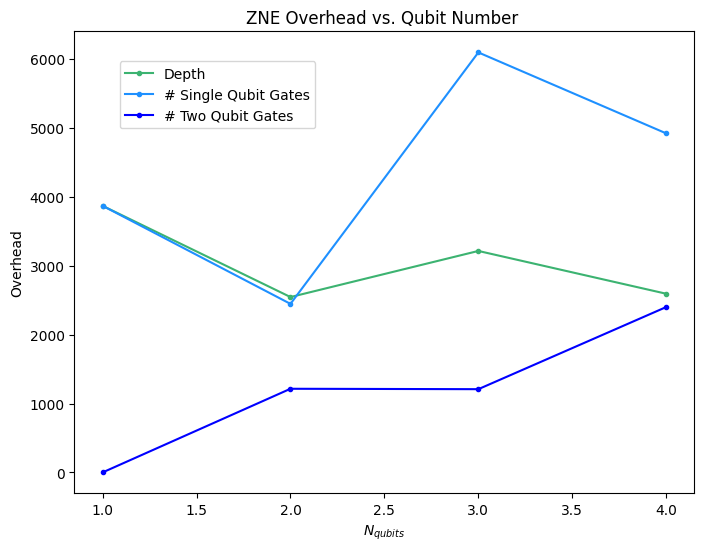

In [152]:
fig, ax = plt.subplots(figsize=(8,6))

c = ax.plot(arr, sums["circuit depth"], '.-', color="mediumseagreen", label='Depth')

n = ax.plot(arr, sums["1 qubit gates"], '.-', color="dodgerblue", label='# Single Qubit Gates')

t  = ax.plot(arr, sums["2 qubit gates"], '.-', color="blue", label='# Two Qubit Gates')

ax.set_xlabel(r'$N_{qubits}$')
ax.set_ylabel('Overhead')
ax.set_title('ZNE Overhead vs. Qubit Number ')

ax.legend(bbox_to_anchor=(0.4, 0.95))